In [8]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity 
import util
from nltk.corpus import stopwords
import pandas as pd



In [9]:
def create_stem_cache(cleaned_description):
    tokenized_description = cleaned_description.apply(lambda s: word_tokenize(s))
    concated = np.unique(np.concatenate([s for s in tokenized_description.values]))
    stem_cache = {}
    ps = PorterStemmer()
    for s in concated:
        stem_cache[s] = ps.stem(s)
    return stem_cache

def create_custom_preprocessor(stop_dict, stem_cache):
    def custom_preprocessor(s) :
        ps = PorterStemmer()
        s = re.sub(r'[^A-Za-z]', ' ', s)
        s = re.sub(r'\s+', ' ' , s)
        s = word_tokenize(s)
        s = list(set(s) - stop_dict)
        s = [word for word in s if len(word) > 2]
        s = [stem_cache[w] if w in stem_cache else ps.stem(w) for w in s]
        s = ' '.join(s)
        return s
    return custom_preprocessor

cleaned_description = util.get_and_clean_data()
stem_cache = create_stem_cache(cleaned_description)
stop_dict = set(stopwords.words('English'))
my_custom_processor = create_custom_preprocessor(stop_dict, stem_cache)

# Vector Technique

In [10]:
arr = np.array([ [100,200,200,50], [90,200,300,0], [5,200,10,200] ])

data = pd.DataFrame(arr, index=['DevOpsHandbook', 'ContinuousDelivery', 'DistributedComputing'], columns=['business','computer', 'git', 'parallel'])
data = np.log10(data + 1)

# print(data.loc['DevOpsHandbook'].dot(data.loc['ContinuousDelivery']))
# print(data.loc['DevOpsHandbook'].dot(data.loc['DistributedComputing']))
# print(data.loc['ContinuousDelivery'].dot(data.loc['DistributedComputing']))
data.loc['DevOpsHandbook'] /= np.sqrt((data.loc['DevOpsHandbook'] ** 2).sum())
data.loc['ContinuousDelivery'] /= np.sqrt((data.loc['ContinuousDelivery'] ** 2).sum())
data.loc['DistributedComputing'] /= np.sqrt((data.loc['DistributedComputing'] ** 2).sum())
data

,business,computer,git,parallel
DevOpsHandbook,0.478543,0.549901,0.549901,0.407692
ContinuousDelivery,0.501071,0.589096,0.633951,0.000000
DistributedComputing,0.221882,0.656732,0.296942,0.656732


In [11]:
tf_idf_vectorizer = TfidfVectorizer(preprocessor=my_custom_processor, use_idf=True)
tf_idf_vectorizer.fit(cleaned_description)
transformed_data = tf_idf_vectorizer.transform(cleaned_description)
X_tfidf_df = pd.DataFrame(transformed_data.toarray(), columns=tf_idf_vectorizer.get_feature_names_out())
max_term = X_tfidf_df.sum().sort_values()[-10:].sort_index().index
X_tfidf_df[max_term].head(5)

,applic,design,develop,employ,provid,requir,respons,system,test,work
0,0.044218,0.046397,0.057155,0.030353,0.028125,0.022774,0.026645,0.000000,0.078244,0.020490
1,0.031692,0.033254,0.054619,0.000000,0.000000,0.032645,0.038194,0.000000,0.000000,0.029371
2,0.047755,0.000000,0.041152,0.032782,0.030375,0.024596,0.000000,0.027089,0.056336,0.044258
3,0.000000,0.000000,0.056202,0.000000,0.041483,0.000000,0.000000,0.036995,0.038469,0.030222
4,0.031692,0.033254,0.054619,0.000000,0.000000,0.032645,0.038194,0.000000,0.000000,0.029371


## Small Workout

### Find top 5 documents relavant to Doc#0


In [22]:
def search_by_ngram(query):
    vectorizer = CountVectorizer(preprocessor=my_custom_processor, ngram_range=(1,2))
    vectorizer.fit(cleaned_description)
    transformed_data = vectorizer.transform(query)
    return  pd.DataFrame(transformed_data.toarray(), columns=vectorizer.get_feature_names_out())

def search_by_tfidf(query):
    tf_idf_vectorizer = TfidfVectorizer(preprocessor=my_custom_processor, use_idf=True)
    tf_idf_vectorizer.fit(cleaned_description)
    transformed_data = tf_idf_vectorizer.transform(query)
    return pd.DataFrame(transformed_data.toarray(), columns=tf_idf_vectorizer.get_feature_names_out())


In [13]:
results = search_by_ngram(cleaned_description[0].split())
max_term = results.sum().sort_values()[-10:].sort_index().index
df = results[max_term].sort_values(max_term[0], ascending=True)[0:6] 
df
# Most relavant doc are 331, 329, 328, 327, 326 and 0(itself)

,aerotek,design,develop,employe,engin,experi,medic,softwar,test,year
0,0,0,0,0,0,0,0,0,0,0
331,0,0,0,0,0,0,0,0,0,0
329,0,0,0,0,0,0,0,0,0,0
328,0,0,0,0,0,0,0,0,0,0
327,0,0,0,1,0,0,0,0,0,0
326,0,0,0,0,0,0,0,0,0,0


In [14]:
results = search_by_tfidf(cleaned_description[0].split())
max_term = results.sum().sort_values()[-10:].sort_index().index
df = results[max_term].sort_values(max_term[0], ascending=True)[0:6]
df
# Most relavant doc are 331, 329, 328, 327, 326, and 0(itself)

,aerotek,design,develop,employe,engin,experi,medic,softwar,test,year
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
327,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Search For AWS devops


In [27]:
results = search_by_tfidf(["aws devops", "aws", "devop" , "devops" , "amazon web service"])
max_term = results.sum().sort_values()[-10:].sort_index().index
df = results[max_term].sort_values(max_term[0], ascending=False)
df
# Most relavant to AWS devop are 4,0,1,2,3

,amazon,aw,devop,servic,web
4,0.57735,0.000000,0.000000,0.57735,0.57735
0,0.00000,0.769447,0.638711,0.00000,0.00000
1,0.00000,1.000000,0.000000,0.00000,0.00000
2,0.00000,0.000000,1.000000,0.00000,0.00000
3,0.00000,0.000000,1.000000,0.00000,0.00000


## BM25


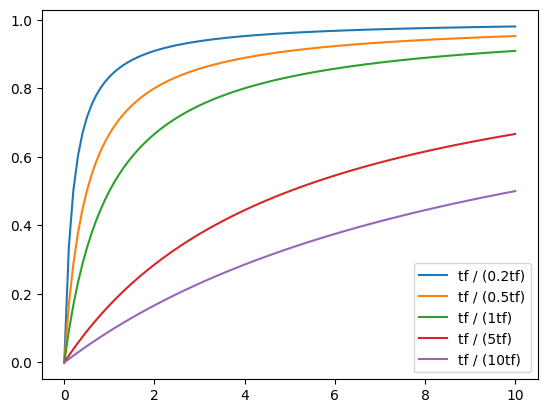

In [31]:
import matplotlib.pyplot as plt
tf = np.linspace(0,10,100)
for k in [0.2,0.5,1,5,10] :
    plt.plot(tf,tf / (k+tf) , label="tf / (" + str(k) +"tf)")
plt.legend()
plt.show()

In [41]:
from scipy import sparse


class BM25(object):
    def __init__(self, vectorizer, b=0.75, k1=1.6):
        self.vectorizer = vectorizer
        self.b = b
        self.k1 = k1
    def fit(self , x):
        self.vectorizer.fit(x)
        self.y = super(TfidfVectorizer, self.vectorizer).transform(x)
        self.avdl = self.y.sum(1).mean()
    def transform(self , q):
        b, k1, avdl = self.b , self.k1, self.avdl
    
        len_y = self.y.sum(1).A1
        q, = super(TfidfVectorizer, self.vectorizer).transform([q])
        assert sparse.isspmatrix_csr(q)

        y = self.y.tocsc()[:, q.indices]
        denom = y + (k1 * (1 - b + b * len_y / avdl))[:, None]
        idf = self.vectorizer._tfidf.idf_[None, q.indices] - 1
        numer = y.multiply(np.broadcast_to(idf, y.shape)) * (k1+1)
        return (numer / denom).sum(1).A1

In [42]:
cleaned_description = util.get_and_clean_data()
bm25 = BM25(tf_idf_vectorizer)
bm25.fit(cleaned_description)

score = bm25.transform('aws devops')
rank = np.argsort(score)[::-1]
cleaned_description.iloc[rank[:5]]

2537    washington dc  devopssoftware developer locati...
2764    washington dc  devopssoftware developer locati...
4770    sr software developer tssci reston va 150k a g...
2096    read what people are saying about working here...
658     sr software developer  aws  irving tx  90 110h...
Name: job_description, dtype: object

In [43]:
score = bm25.transform('aws github')
rank = np.argsort(score)[::-1]
cleaned_description.iloc[rank[:5]]

9195    software developer  reston virginia software d...
5635    we are currently seeking a full stack net deve...
4273    responsibilities kforce has a client in search...
3       our client a multinational publishing and educ...
5918    job description  as a software developer you w...
Name: job_description, dtype: object